In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import hamming_loss, jaccard_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import time
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import uniform, randint
import warnings
from IPython.display import display, Markdown, HTML
import matplotlib.ticker as mtick
from matplotlib.colors import LinearSegmentedColormap

# Suppress warnings for cleaner notebook output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Create custom colormap for heatmaps
colors = ["#f7fbff", "#08306b"]  # Light blue to dark blue
cmap_blue = LinearSegmentedColormap.from_list("custom_blue", colors)

# Display title
display(HTML("<h1 style='color:#0066CC;'>Multi-Label Disease Classification with Random Forest Model</h1>"))


In [4]:
def load_data(file_path):
    """
    Load the dataset from a CSV file with visualization of sample data.
    
    Args:
        file_path (str): Path to the CSV file containing the dataset.
    
    Returns:
        pd.DataFrame: The loaded dataset.
    """
    display(Markdown("## 1. Data Loading"))
    print(f"Loading data from {file_path}")
    
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully with shape: {df.shape}")
        
        # Display sample data
        display(Markdown("### Sample data:"))
        display(df.head())
        
        # Create visualization of dataset size
        plt.figure(figsize=(8, 2))
        plt.barh(['Rows', 'Columns'], [df.shape[0], df.shape[1]], color=['#3498db', '#2ecc71'])
        plt.title('Dataset Dimensions')
        plt.tight_layout()
        plt.show()
        
        return df
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return None
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

In [5]:
def preprocess_data(df):
    """
    Preprocess the dataset with visualizations of data characteristics.
    
    Args:
        df (pd.DataFrame): The raw dataset.
    
    Returns:
        tuple: Processed features (X) and labels (y).
    """
    display(Markdown("## 2. Data Preprocessing and Exploratory Analysis"))
    
    # Define feature and target columns
    feature_cols = ['DO', 'pH', 'Alkalinity', 'Hardness', 'Nitrite', 'H2S', 
                   'Salinity', 'Ammonia', 'Temperature']
    target_cols = ['WSS', 'AHPND', 'TSV', 'YHV']
    
    # Basic statistics of the dataset
    display(Markdown("### Feature Statistics:"))
    display(df[feature_cols].describe().round(2))
    
    # Visualize feature distributions
    display(Markdown("### Feature Distributions:"))
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, col in enumerate(feature_cols):
        sns.histplot(df[col], kde=True, ax=axes[i], color='#3498db')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Class distribution
    display(Markdown("### Class Distribution:"))
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(target_cols):
        value_counts = df[col].value_counts()
        axes[i].pie(value_counts, labels=['Negative (0)', 'Positive (1)'], 
                 autopct='%1.1f%%', colors=['#3498db', '#e74c3c'],
                 textprops={'fontsize': 12})
        axes[i].set_title(f'Distribution of {col}')
    
    plt.tight_layout()
    plt.show()
    
    # Check for missing values
    missing_values = df.isnull().sum()
    
    if missing_values.sum() > 0:
        display(Markdown("### Missing Values:"))
        missing_df = pd.DataFrame({
            'Column': missing_values.index,
            'Missing Values': missing_values.values,
            'Percentage': (missing_values.values / len(df) * 100).round(2)
        })
        display(missing_df[missing_df['Missing Values'] > 0])
        
        # Visualize missing values
        plt.figure(figsize=(10, 6))
        sns.barplot(x=missing_df[missing_df['Missing Values'] > 0]['Column'], 
                   y=missing_df[missing_df['Missing Values'] > 0]['Percentage'],
                   color='#e74c3c')
        plt.title('Percentage of Missing Values by Column')
        plt.xticks(rotation=45)
        plt.ylabel('Percentage (%)')
        plt.tight_layout()
        plt.show()
        
        print("Filling missing values with median values")
        df = df.fillna(df.median())
    else:
        print("No missing values detected.")
    
    # Feature correlations
    display(Markdown("### Feature Correlations:"))
    plt.figure(figsize=(12, 10))
    corr_matrix = df[feature_cols].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
               vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
    plt.title('Feature Correlation Matrix', fontsize=15)
    plt.tight_layout()
    plt.show()
    
    # Disease co-occurrence
    display(Markdown("### Disease Co-occurrence:"))
    plt.figure(figsize=(10, 8))
    disease_corr = df[target_cols].corr()
    sns.heatmap(disease_corr, annot=True, fmt='.2f', cmap='coolwarm',
               vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
    plt.title('Disease Co-occurrence Matrix', fontsize=15)
    plt.tight_layout()
    plt.show()
    
    # Extract features and labels
    X = df[feature_cols].values
    y = df[target_cols].values
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Visualize features before and after scaling
    display(Markdown("### Feature Scaling Effect:"))
    feature_idx = 0  # First feature for demonstration
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(X[:, feature_idx], kde=True, color='#3498db')
    plt.title(f'{feature_cols[feature_idx]} Before Scaling')
    
    plt.subplot(1, 2, 2)
    sns.histplot(X_scaled[:, feature_idx], kde=True, color='#2ecc71')
    plt.title(f'{feature_cols[feature_idx]} After Scaling')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFeatures shape after preprocessing: {X_scaled.shape}")
    print(f"Labels shape after preprocessing: {y.shape}")
    
    return X_scaled, y, scaler, feature_cols, target_cols

In [6]:
def split_data(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and testing sets with visualization.
    
    Args:
        X (np.ndarray): Features.
        y (np.ndarray): Labels.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Random seed for reproducibility.
    
    Returns:
        tuple: X_train, X_test, y_train, y_test.
    """
    display(Markdown("## 3. Train-Test Split"))
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y[:, 0]
    )
    
    # Display split information
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Testing set size: {X_test.shape[0]} samples")
    
    # Visualize the split
    plt.figure(figsize=(10, 5))
    plt.pie([X_train.shape[0], X_test.shape[0]], 
            labels=[f'Training ({X_train.shape[0]})', f'Testing ({X_test.shape[0]})'],
            autopct='%1.1f%%',
            colors=['#3498db', '#e74c3c'],
            explode=[0, 0.1],
            shadow=True)
    plt.title('Train-Test Split')
    plt.tight_layout()
    plt.show()
    
    # Visualize class distribution in train and test sets
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Training set class distribution
    train_positives = y_train.sum(axis=0)
    train_negatives = y_train.shape[0] - train_positives
    
    axes[0].bar(range(len(train_positives)), train_positives, label='Positive', color='#e74c3c')
    axes[0].bar(range(len(train_negatives)), train_negatives, bottom=train_positives, 
             label='Negative', color='#3498db')
    axes[0].set_xticks(range(len(train_positives)))
    axes[0].set_xticklabels(target_cols)
    axes[0].set_title('Training Set Class Distribution')
    axes[0].set_ylabel('Number of Samples')
    axes[0].legend()
    
    # Testing set class distribution
    test_positives = y_test.sum(axis=0)
    test_negatives = y_test.shape[0] - test_positives
    
    axes[1].bar(range(len(test_positives)), test_positives, label='Positive', color='#e74c3c')
    axes[1].bar(range(len(test_negatives)), test_negatives, bottom=test_positives, 
             label='Negative', color='#3498db')
    axes[1].set_xticks(range(len(test_positives)))
    axes[1].set_xticklabels(target_cols)
    axes[1].set_title('Testing Set Class Distribution')
    axes[1].set_ylabel('Number of Samples')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return X_train, X_test, y_train, y_test


In [7]:
def hyperparameter_tune_rf(X_train, y_train, target_cols, random_state=42):
    """
    Perform hyperparameter tuning for Random Forest model with visualization of search results.
    
    Args:
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels (multi-label binary format).
        target_cols (list): Names of target columns.
        random_state (int): Random seed for reproducibility.
        
    Returns:
        tuple: Best Random Forest parameters and best estimator.
    """
    display(Markdown("## 4. Hyperparameter Tuning for Random Forest"))
    
    # We'll tune for the first disease to save time
    first_disease = target_cols[0]
    print(f"Tuning hyperparameters using {first_disease} as target...")
    
    # Define hyperparameter grid for Random Forest
    param_grid = {
        'n_estimators': randint(50, 500),
        'max_depth': [None, 10, 20, 30, 50, 100],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False],
        'class_weight': ['balanced', 'balanced_subsample', None],
    }
    
    # Create base Random Forest model
    base_model = RandomForestClassifier(random_state=random_state)
    
    # Set up RandomizedSearchCV
    print("Starting hyperparameter search for Random Forest (this may take a while)...")
    
    # Create progress tracker for visual feedback
    start_time = time.time()
    
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter settings sampled
        cv=3,  # 3-fold cross-validation
        scoring='f1',
        random_state=random_state,
        n_jobs=-1,  # Use all available cores
        verbose=1
    )
    
    # Fit the model using the first disease as target
    search.fit(X_train, y_train[:, 0])
    
    end_time = time.time()
    
    print(f"\nHyperparameter tuning completed in {end_time - start_time:.2f} seconds.")
    print(f"Best parameters: {search.best_params_}")
    print(f"Best cross-validation score: {search.best_score_:.4f}")
    
    # Visualize hyperparameter search results
    display(Markdown("### Hyperparameter Search Results:"))
    
    # Convert results to DataFrame for visualization
    results_df = pd.DataFrame(search.cv_results_)
    
    # Prepare data for plotting
    plot_df = pd.DataFrame({
        'Iteration': range(1, len(results_df) + 1),
        'F1 Score': results_df['mean_test_score'],
        'n_estimators': results_df['param_n_estimators'].astype(str),
        'max_depth': results_df['param_max_depth'].astype(str),
        'max_features': results_df['param_max_features'].astype(str),
        'bootstrap': results_df['param_bootstrap'].astype(str)
    })
    
    # Plot score vs iteration
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    sns.lineplot(x='Iteration', y='F1 Score', data=plot_df, marker='o', markersize=8)
    plt.axhline(y=search.best_score_, color='r', linestyle='--', label=f'Best score: {search.best_score_:.4f}')
    plt.title('F1 Score by Search Iteration')
    plt.legend()
    
    # Plot score by n_estimators
    plt.subplot(2, 2, 2)
    boxplot = sns.boxplot(x='max_features', y='F1 Score', data=plot_df)
    plt.title('F1 Score Distribution by max_features')
    plt.xticks(rotation=45)
    
    # Plot score by bootstrap
    plt.subplot(2, 2, 3)
    boxplot = sns.boxplot(x='bootstrap', y='F1 Score', data=plot_df)
    plt.title('F1 Score Distribution by bootstrap')
    
    # Plot n_estimators vs score
    plt.subplot(2, 2, 4)
    # Convert n_estimators to numeric
    plot_df['n_estimators_num'] = plot_df['n_estimators'].astype(float)
    plt.scatter(plot_df['n_estimators_num'], plot_df['F1 Score'], c=plot_df.index, cmap='viridis', s=50)
    plt.xlabel('Number of Estimators')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Number of Estimators')
    plt.colorbar(label='Iteration', ticks=[0, len(plot_df)-1])
    
    plt.tight_layout()
    plt.show()
    
    # Display best parameters in a table
    display(Markdown("### Best Random Forest Hyperparameters:"))
    best_params_df = pd.DataFrame({
        'Parameter': list(search.best_params_.keys()),
        'Value': [str(v) for v in search.best_params_.values()]
    })
    display(best_params_df)
    
    return search.best_params_, search.best_estimator_

In [8]:
def train_random_forest_models(X_train, X_test, y_train, y_test, best_params, target_cols, random_state=42):
    """
    Train Random Forest models for each disease with detailed performance visualization.
    
    Args:
        X_train (np.ndarray): Training features.
        X_test (np.ndarray): Testing features.
        y_train (np.ndarray): Training labels (multi-label binary format).
        y_test (np.ndarray): Testing labels (multi-label binary format).
        best_params (dict): Best hyperparameters from tuning.
        target_cols (list): Names of target columns.
        random_state (int): Random seed for reproducibility.
        
    Returns:
        tuple: Trained models and evaluation results.
    """
    display(Markdown("## 5. Training Random Forest Models"))
    
    # Initialize storage for results
    models = {}
    results = {}
    all_predictions = np.zeros_like(y_test)
    all_probabilities = np.zeros_like(y_test, dtype=float)
    
    # Training progress data
    training_data = []
    
    # Loop through each disease
    for i, disease in enumerate(target_cols):
        print(f"\nTraining Random Forest for {disease}...")
        start_time = time.time()
        
        # Create Random Forest with best parameters
        rf = RandomForestClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            max_features=best_params['max_features'],
            bootstrap=best_params['bootstrap'],
            class_weight=best_params['class_weight'],
            random_state=random_state,
            n_jobs=-1
        )
        
        # Train model
        rf.fit(X_train, y_train[:, i])
        
        # Make predictions
        y_pred = rf.predict(X_test)
        y_prob = rf.predict_proba(X_test)[:, 1] if hasattr(rf, 'predict_proba') else y_pred
        
        # Store predictions
        all_predictions[:, i] = y_pred
        all_probabilities[:, i] = y_prob
        
        # Calculate metrics
        accuracy = accuracy_score(y_test[:, i], y_pred)
        precision = precision_score(y_test[:, i], y_pred, zero_division=0)
        recall = recall_score(y_test[:, i], y_pred, zero_division=0)
        f1 = f1_score(y_test[:, i], y_pred, zero_division=0)
        cm = confusion_matrix(y_test[:, i], y_pred)
        
        # Store model and results
        models[disease] = rf
        results[disease] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'y_true': y_test[:, i],
            'y_pred': y_pred,
            'y_prob': y_prob
        }
        
        # Record training time
        end_time = time.time()
        training_time = end_time - start_time
        
        # Add to progress data
        training_data.append({
            'Disease': disease,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Training Time': training_time
        })
        
        # Print metrics
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  Training time: {training_time:.2f} seconds")
    
    # Visualize model performance
    training_df = pd.DataFrame(training_data)
    
    # Plot metrics by disease
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    sns.barplot(x='Disease', y='Accuracy', data=training_df, palette='viridis')
    plt.title('Accuracy by Disease')
    plt.ylim(0, 1)
    
    plt.subplot(2, 2, 2)
    sns.barplot(x='Disease', y='Precision', data=training_df, palette='viridis')
    plt.title('Precision by Disease')
    plt.ylim(0, 1)
    
    plt.subplot(2, 2, 3)
    sns.barplot(x='Disease', y='Recall', data=training_df, palette='viridis')
    plt.title('Recall by Disease')
    plt.ylim(0, 1)
    
    plt.subplot(2, 2, 4)
    sns.barplot(x='Disease', y='F1', data=training_df, palette='viridis')
    plt.title('F1 Score by Disease')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize training time
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Disease', y='Training Time', data=training_df, palette='viridis')
    plt.title('Training Time by Disease')
    plt.ylabel('Time (seconds)')
    plt.tight_layout()
    plt.show()
    
    # Visualize confusion matrices
    display(Markdown("### Confusion Matrices:"))
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for i, disease in enumerate(target_cols):
        cm = results[disease]['confusion_matrix']
        
        # Normalize confusion matrix for better visualization
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Plot regular confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap_blue, ax=axes[i])
        axes[i].set_title(f'Confusion Matrix: {disease}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_xticklabels(['Negative', 'Positive'])
        axes[i].set_yticklabels(['Negative', 'Positive'])
    
    plt.tight_layout()
    plt.show()
    
    # Calculate overall metrics
    accuracy = accuracy_score(y_test, all_predictions)
    hamming = hamming_loss(y_test, all_predictions)
    jaccard = jaccard_score(y_test, all_predictions, average='samples')
    
    # Store overall results
    results['overall'] = {
        'accuracy': accuracy,
        'hamming_loss': hamming,
        'jaccard_score': jaccard,
        'model_name': 'Random Forest'
    }
    
    display(Markdown("### Overall Model Performance:"))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"Jaccard Score: {jaccard:.4f}")
    
    # Visualize overall metrics
    plt.figure(figsize=(10, 6))
    metrics = ['Accuracy', 'Jaccard Score', '1 - Hamming Loss']
    values = [accuracy, jaccard, 1 - hamming]  # Invert Hamming Loss for visualization
    
    # Create gauge chart-like visualization
    sns.barplot(x=metrics, y=values, palette='viridis')
    plt.ylim(0, 1)
    plt.title('Overall Model Performance Metrics')
    plt.ylabel('Score (higher is better)')
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
    plt.axhline(y=0.75, color='g', linestyle='--', alpha=0.3)
    
    # Add percentage labels
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.1%}", ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Feature importance analysis
    display(Markdown("### Feature Importance Analysis:"))
    
    # Get feature importance from all models
    feature_importance = np.zeros((len(target_cols), len(feature_cols)))
    
    for i, disease in enumerate(target_cols):
        importance = models[disease].feature_importances_
        feature_importance[i] = importance
    
    # Average importance across all models
    avg_importance = np.mean(feature_importance, axis=0)
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': avg_importance
    }).sort_values('Importance', ascending=False)
    
    # Plot overall feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Average Feature Importance Across All Disease Models')
    plt.tight_layout()
    plt.show()
    
    # Plot feature importance by disease
    plt.figure(figsize=(14, 10))
    
    importance_by_disease = pd.DataFrame(feature_importance, 
                                       index=target_cols, 
                                       columns=feature_cols)
    
    # Heatmap of feature importance by disease
    sns.heatmap(importance_by_disease, cmap='viridis', annot=True, fmt='.3f')
    plt.title('Feature Importance by Disease')
    plt.tight_layout()
    plt.show()
    return models, results

In [9]:
def save_model(models, scaler, results, best_params, feature_cols, target_cols, output_dir='model'):
    """
    Save trained models and related artifacts.
    
    Args:
        models (dict): Trained RF models for each disease.
        scaler (StandardScaler): Feature scaler.
        results (dict): Model evaluation results.
        best_params (dict): Best hyperparameters.
        feature_cols (list): Feature column names.
        target_cols (list): Target column names.
        output_dir (str): Directory to save models and artifacts.
    """
    display(Markdown("## 6. Saving Models and Artifacts"))
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save models
    for disease, model in models.items():
        model_path = os.path.join(output_dir, f"rf_model_{disease}.pkl")
        joblib.dump(model, model_path)
        print(f"Saved model for {disease} to {model_path}")
    
    # Save scaler
    scaler_path = os.path.join(output_dir, "scaler.pkl")
    joblib.dump(scaler, scaler_path)
    print(f"Saved scaler to {scaler_path}")
    
    # Save metadata
    metadata = {
        'feature_columns': feature_cols,
        'target_columns': target_cols,
        'best_parameters': best_params,
        'results': results
    }
    
    metadata_path = os.path.join(output_dir, "metadata.pkl")
    joblib.dump(metadata, metadata_path)
    print(f"Saved metadata to {metadata_path}")
    
    # Save summary
    summary_path = os.path.join(output_dir, "model_summary.txt")
    
    with open(summary_path, 'w') as f:
        f.write("Random Forest Multi-Label Classification Model Summary\n")
        f.write("="*60 + "\n\n")
        
        f.write("1. Features:\n")
        for col in feature_cols:
            f.write(f"   - {col}\n")
        
        f.write("\n2. Target Diseases:\n")
        for col in target_cols:
            f.write(f"   - {col}\n")
        
        f.write("\n3. Best Hyperparameters:\n")
        for param, value in best_params.items():
            f.write(f"   - {param}: {value}\n")
        
        f.write("\n4. Model Performance:\n")
        
        f.write("\n   Per-Disease Metrics:\n")
        for disease in target_cols:
            f.write(f"   {disease}:\n")
            f.write(f"     - Accuracy:  {results[disease]['accuracy']:.4f}\n")
            f.write(f"     - Precision: {results[disease]['precision']:.4f}\n")
            f.write(f"     - Recall:    {results[disease]['recall']:.4f}\n")
            f.write(f"     - F1 Score:  {results[disease]['f1']:.4f}\n")
        
        f.write("\n   Overall Metrics:\n")
        f.write(f"     - Accuracy:     {results['overall']['accuracy']:.4f}\n")
        f.write(f"     - Hamming Loss: {results['overall']['hamming_loss']:.4f}\n")
        f.write(f"     - Jaccard Score: {results['overall']['jaccard_score']:.4f}\n")
    
    print(f"Saved model summary to {summary_path}")
    
    # Create a simple plot showing where files were saved
    plt.figure(figsize=(10, 4))
    files = ['RF Models', 'Scaler', 'Metadata', 'Summary']
    plt.barh(files, [1, 1,1, 1], color=['#3498db', '#2ecc71', '#9b59b6', '#f1c40f'])
    plt.title('Model Artifacts Saved')
    plt.xlabel('Status (Completed)')
    plt.tight_layout()
    plt.show()
    
    return summary_path

In [10]:
def predict_new_cases(models, scaler, feature_cols, target_cols, new_data, visualize=True):
    """
    Make predictions on new data with visualization of prediction probabilities.
    
    Args:
        models (dict): Trained RF models for each disease.
        scaler (StandardScaler): Feature scaler.
        feature_cols (list): Feature column names.
        target_cols (list): Target column names.
        new_data (pd.DataFrame or np.ndarray): New data for prediction.
        visualize (bool): Whether to visualize predictions.
        
    Returns:
        pd.DataFrame: Predictions with probabilities.
    """
    display(Markdown("## 7. Prediction on New Data"))
    
    # Convert input to DataFrame if numpy array
    if isinstance(new_data, np.ndarray):
        new_data = pd.DataFrame(new_data, columns=feature_cols)
    
    # Display input data
    display(Markdown("### Input Data:"))
    display(new_data)
    
    # Check if all required features are present
    missing_features = set(feature_cols) - set(new_data.columns)
    if missing_features:
        raise ValueError(f"Missing features in input data: {missing_features}")
    
    # Extract features
    X_new = new_data[feature_cols].values
    
    # Scale features
    X_new_scaled = scaler.transform(X_new)
    
    # Make predictions for each disease
    predictions = np.zeros((X_new.shape[0], len(target_cols)))
    probabilities = np.zeros((X_new.shape[0], len(target_cols)))
    
    for i, disease in enumerate(target_cols):
        model = models[disease]
        
        # Predict class
        predictions[:, i] = model.predict(X_new_scaled)
        
        # Predict probability if available
        if hasattr(model, 'predict_proba'):
            # Get probability for positive class
            probabilities[:, i] = model.predict_proba(X_new_scaled)[:, 1]
        else:
            probabilities[:, i] = predictions[:, i]
    
    # Create results DataFrame
    results_df = pd.DataFrame()
    
    # Add sample identifier
    results_df['Sample'] = [f"Sample {i+1}" for i in range(X_new.shape[0])]
    
    # Add prediction and probability for each disease
    for i, disease in enumerate(target_cols):
        results_df[f"{disease}_Prediction"] = predictions[:, i].astype(int)
        results_df[f"{disease}_Probability"] = probabilities[:, i]
    
    # Visualize predictions if requested
    if visualize and len(new_data) > 0:
        # Heatmap of prediction probabilities
        display(Markdown("### Prediction Probabilities:"))
        
        # Prepare data for heatmap
        heatmap_data = pd.DataFrame(
            probabilities, 
            columns=target_cols, 
            index=[f"Sample {i+1}" for i in range(X_new.shape[0])]
        )
        
        plt.figure(figsize=(12, max(4, len(new_data) * 0.5)))
        sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='.3f', 
                   cbar_kws={'label': 'Probability'})
        plt.title('Disease Prediction Probabilities')
        plt.tight_layout()
        plt.show()
        
        # Binary prediction visualization
        display(Markdown("### Binary Predictions:"))
        
        # Prepare data for binary heatmap
        binary_data = pd.DataFrame(
            predictions, 
            columns=target_cols, 
            index=[f"Sample {i+1}" for i in range(X_new.shape[0])]
        )
        
        plt.figure(figsize=(12, max(4, len(new_data) * 0.5)))
        sns.heatmap(binary_data, cmap=LinearSegmentedColormap.from_list("custom", ["#f7fbff", "#e74c3c"]), 
                   annot=True, fmt='d', cbar=False)
        plt.title('Disease Binary Predictions (0: Negative, 1: Positive)')
        plt.tight_layout()
        plt.show()
    
    return results_df

In [12]:
def evaluate_with_cv(X, y, best_params, feature_cols, target_cols, n_splits=5, random_state=42):
    """
    Evaluate Random Forest model using cross-validation with visualizations.
    
    Args:
        X (np.ndarray): Features.
        y (np.ndarray): Labels.
        best_params (dict): Best hyperparameters.
        feature_cols (list): Feature column names.
        target_cols (list): Target column names.
        n_splits (int): Number of CV splits.
        random_state (int): Random seed for reproducibility.
        
    Returns:
        dict: Cross-validation results.
    """
    display(Markdown("## 8. Cross-Validation Evaluation"))
    
    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Initialize results storage
    cv_results = {disease: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} 
                 for disease in target_cols}
    cv_results['overall'] = {'accuracy': [], 'hamming_loss': [], 'jaccard_score': []}
    
    # Display CV progress
    print(f"Performing {n_splits}-fold cross-validation...")
    
    # Perform CV
    fold = 1
    for train_index, test_index in kf.split(X):
        print(f"\nFold {fold}/{n_splits}")
        
        # Split data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Initialize predictions array
        all_predictions = np.zeros_like(y_test)
        
        # Train model for each disease
        for i, disease in enumerate(target_cols):
            print(f"  Training for {disease}...")
            
            # Create RF model with best parameters
            rf = RandomForestClassifier(
                n_estimators=best_params['n_estimators'],
                max_depth=best_params['max_depth'],
                min_samples_split=best_params['min_samples_split'],
                min_samples_leaf=best_params['min_samples_leaf'],
                max_features=best_params['max_features'],
                bootstrap=best_params['bootstrap'],
                class_weight=best_params['class_weight'],
                random_state=random_state,
                n_jobs=-1
            )
            
            # Train model
            rf.fit(X_train, y_train[:, i])
            
            # Make predictions
            y_pred = rf.predict(X_test)
            all_predictions[:, i] = y_pred
            
            # Calculate metrics
            accuracy = accuracy_score(y_test[:, i], y_pred)
            precision = precision_score(y_test[:, i], y_pred, zero_division=0)
            recall = recall_score(y_test[:, i], y_pred, zero_division=0)
            f1 = f1_score(y_test[:, i], y_pred, zero_division=0)
            
            # Store results
            cv_results[disease]['accuracy'].append(accuracy)
            cv_results[disease]['precision'].append(precision)
            cv_results[disease]['recall'].append(recall)
            cv_results[disease]['f1'].append(f1)
            
            print(f"    Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        # Calculate overall metrics
        accuracy = accuracy_score(y_test, all_predictions)
        hamming = hamming_loss(y_test, all_predictions)
        jaccard = jaccard_score(y_test, all_predictions, average='samples')
        
        # Store overall results
        cv_results['overall']['accuracy'].append(accuracy)
        cv_results['overall']['hamming_loss'].append(hamming)
        cv_results['overall']['jaccard_score'].append(jaccard)
        
        print(f"  Overall Accuracy: {accuracy:.4f}, Hamming Loss: {hamming:.4f}")
        
        fold += 1
    
    # Calculate mean and std for each metric
    cv_summary = {}
    
    for disease in target_cols + ['overall']:
        cv_summary[disease] = {}
        
        for metric in cv_results[disease]:
            values = cv_results[disease][metric]
            cv_summary[disease][f"{metric}_mean"] = np.mean(values)
            cv_summary[disease][f"{metric}_std"] = np.std(values)
    
    # Display CV summary
    display(Markdown("### Cross-Validation Summary:"))
    
    # Create summary table
    summary_rows = []
    
    # Per-disease metrics
    for disease in target_cols:
        summary_rows.append({
            'Disease/Metric': disease,
            'Accuracy': f"{cv_summary[disease]['accuracy_mean']:.4f} ± {cv_summary[disease]['accuracy_std']:.4f}",
            'Precision': f"{cv_summary[disease]['precision_mean']:.4f} ± {cv_summary[disease]['precision_std']:.4f}",
            'Recall': f"{cv_summary[disease]['recall_mean']:.4f} ± {cv_summary[disease]['recall_std']:.4f}",
            'F1 Score': f"{cv_summary[disease]['f1_mean']:.4f} ± {cv_summary[disease]['f1_std']:.4f}"
        })
    
    # Overall metrics
    summary_rows.append({
        'Disease/Metric': 'Overall',
        'Accuracy': f"{cv_summary['overall']['accuracy_mean']:.4f} ± {cv_summary['overall']['accuracy_std']:.4f}",
        'Precision': 'N/A',
        'Recall': 'N/A',
        'F1 Score': f"{cv_summary['overall']['jaccard_score_mean']:.4f} ± {cv_summary['overall']['jaccard_score_std']:.4f}"
    })
    
    # Display summary table
    summary_df = pd.DataFrame(summary_rows)
    display(summary_df)
    
    # Visualize CV results
    display(Markdown("### Cross-Validation Performance Visualization:"))
    
    # Prepare data for visualization
    vis_data = []
    
    for disease in target_cols:
        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            for fold, value in enumerate(cv_results[disease][metric], 1):
                vis_data.append({
                    'Disease': disease,
                    'Metric': metric.capitalize(),
                    'Fold': f"Fold {fold}",
                    'Value': value
                })
    
    # Convert to DataFrame
    vis_df = pd.DataFrame(vis_data)
    
    # Create grid of box plots
    plt.figure(figsize=(14, 10))
    
    sns.boxplot(x='Disease', y='Value', hue='Metric', data=vis_df, palette='viridis')
    plt.title('Cross-Validation Metrics Distribution by Disease')
    plt.ylim(0, 1)
    plt.legend(title='Metric')
    
    plt.tight_layout()
    plt.show()
    
    # Visualize overall metrics
    plt.figure(figsize=(10, 6))
    
    # Prepare data
    overall_data = []
    
    for metric in ['accuracy', 'hamming_loss', 'jaccard_score']:
        for fold, value in enumerate(cv_results['overall'][metric], 1):
            # Invert hamming loss for better visualization (lower is better)
            if metric == 'hamming_loss':
                value = 1 - value
                display_metric = '1 - Hamming Loss'
            else:
                display_metric = ' '.join(word.capitalize() for word in metric.split('_'))
            
            overall_data.append({
                'Metric': display_metric,
                'Fold': f"Fold {fold}",
                'Value': value
            })
    
    # Convert to DataFrame
    overall_df = pd.DataFrame(overall_data)
    
    # Create bar plot
    plt.figure(figsize=(12, 6))
    
    sns.barplot(x='Metric', y='Value', hue='Fold', data=overall_df, palette='viridis')
    plt.title('Overall Cross-Validation Metrics by Fold')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    return cv_summary

In [13]:
def run_pipeline(data_path, test_size=0.2, random_state=42):
    """
    Run the complete multi-label disease classification pipeline.
    
    Args:
        data_path (str): Path to the dataset.
        test_size (float): Proportion for test split.
        random_state (int): Random seed for reproducibility.
        
    Returns:
        dict: Results and artifacts from the pipeline.
    """
    display(HTML("<h1 style='color:#0066CC;'>Complete Random Forest Pipeline Execution</h1>"))
    
    # 1. Load Data
    df = load_data(data_path)
    if df is None:
        return None
    
    # 2. Preprocess Data
    X, y, scaler, feature_cols, target_cols = preprocess_data(df)
    
    # 3. Split Data
    X_train, X_test, y_train, y_test = split_data(X, y, test_size, random_state)
    
    # 4. Hyperparameter Tuning
    best_params, _ = hyperparameter_tune_rf(X_train, y_train, target_cols, random_state)
    
    # 5. Train Models
    models, results = train_random_forest_models(X_train, X_test, y_train, y_test, 
                                              best_params, target_cols, random_state)
    
    # 6. Save Models
    summary_path = save_model(models, scaler, results, best_params, feature_cols, target_cols)
    
    # 7. Cross-Validation Evaluation
    cv_results = evaluate_with_cv(X, y, best_params, feature_cols, target_cols, n_splits=5, random_state=random_state)
    
    # 8. Sample prediction
    # Create sample data (using first few test samples)
    sample_data = pd.DataFrame(X_test[:3], columns=feature_cols)
    
    # Make predictions
    predictions = predict_new_cases(models, scaler, feature_cols, target_cols, sample_data)
    
    # Create final summary
    display(Markdown("## Final Pipeline Summary"))
    
    # Display overall performance
    print(f"Random Forest Models for {len(target_cols)} diseases:")
    for disease in target_cols:
        print(f"  - {disease}: F1 Score = {results[disease]['f1']:.4f}")
    
    print(f"\nOverall Accuracy: {results['overall']['accuracy']:.4f}")
    print(f"Hamming Loss: {results['overall']['hamming_loss']:.4f}")
    print(f"Jaccard Score: {results['overall']['jaccard_score']:.4f}")
    
    print(f"\nModels and artifacts saved to directory.")
    
    # Final output visualization
    plt.figure(figsize=(12, 8))
    
    # Create model performance summary chart
    metrics_data = []
    
    for disease in target_cols:
        metrics_data.append({
            'Disease': disease,
            'Accuracy': results[disease]['accuracy'],
            'Precision': results[disease]['precision'],
            'Recall': results[disease]['recall'],
            'F1 Score': results[disease]['f1']
        })
    
    # Convert to DataFrame for plotting
    metrics_df = pd.DataFrame(metrics_data)
    
    # Melt DataFrame for easier plotting
    melted_df = pd.melt(metrics_df, id_vars=['Disease'], 
                       value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                       var_name='Metric', value_name='Value')
    
    # Plot metrics
    plt.subplot(2, 1, 1)
    sns.barplot(x='Disease', y='Value', hue='Metric', data=melted_df, palette='viridis')
    plt.title('Model Performance by Disease and Metric')
    plt.ylim(0, 1)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot overall metrics
    plt.subplot(2, 1, 2)
    overall_metrics = ['Accuracy', 'Jaccard Score', '1 - Hamming Loss']
    overall_values = [
        results['overall']['accuracy'], 
        results['overall']['jaccard_score'],
        1 - results['overall']['hamming_loss']
    ]
    
    bars = plt.bar(overall_metrics, overall_values, color=['#3498db', '#2ecc71', '#9b59b6'])
    plt.ylim(0, 1)
    plt.title('Overall Model Performance')
    
    # Add percentage labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.1%}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'models': models,
        'scaler': scaler,
        'results': results,
        'cv_results': cv_results,
        'feature_cols': feature_cols,
        'target_cols': target_cols,
        'best_params': best_params
    }

## 1. Data Loading

Loading data from C:\Users\naren\Desktop\4thyear models\Untitled Folder\dataset.csv
Dataset loaded successfully with shape: (6517, 13)


### Sample data:

,DO,pH,Alkalinity,Hardness,Nitrite,H2S,Salinity,Ammonia,Temperature,WSS,AHPND,TSV,YHV
0,0.21,4.75,218.36,300.13,4.36,0.07,24.44,5.90,35.18,1,1,1,1
1,11.43,3.09,273.94,8.43,2.18,0.02,10.08,0.73,36.45,0,0,0,1
2,12.43,9.65,220.81,11.73,4.90,0.07,11.29,4.88,33.51,0,1,0,1
3,10.96,4.82,266.57,6.63,3.57,0.03,23.82,0.99,30.07,0,0,0,0
4,1.36,10.24,252.11,339.89,4.66,0.06,13.43,3.81,30.72,1,1,1,1


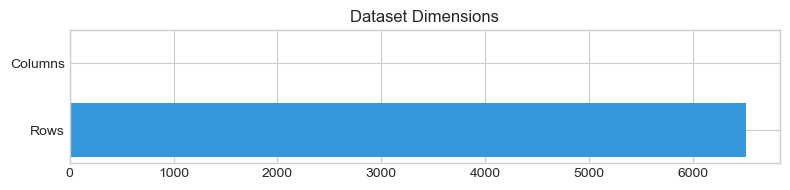

## 2. Data Preprocessing and Exploratory Analysis

### Feature Statistics:

,DO,pH,Alkalinity,Hardness,Nitrite,H2S,Salinity,Ammonia,Temperature
count,6517.00,6517.00,6517.00,6517.00,6517.00,6517.00,6517.00,6517.00,6517.00
mean,5.53,7.88,99.74,155.28,0.56,0.08,18.79,2.04,32.29
std,1.70,1.41,60.00,89.41,0.75,0.11,4.44,1.84,2.63
min,0.03,0.00,20.00,0.00,0.00,0.00,10.01,0.00,28.00
25%,4.31,6.87,48.24,90.01,0.02,0.01,14.98,0.52,30.01
50%,5.43,8.00,94.88,142.40,0.35,0.02,20.13,1.13,32.21
75%,6.66,9.00,121.00,212.37,0.65,0.10,22.65,3.57,34.56
max,14.97,14.85,480.00,816.00,4.99,0.49,25.00,6.00,37.00


### Feature Distributions:

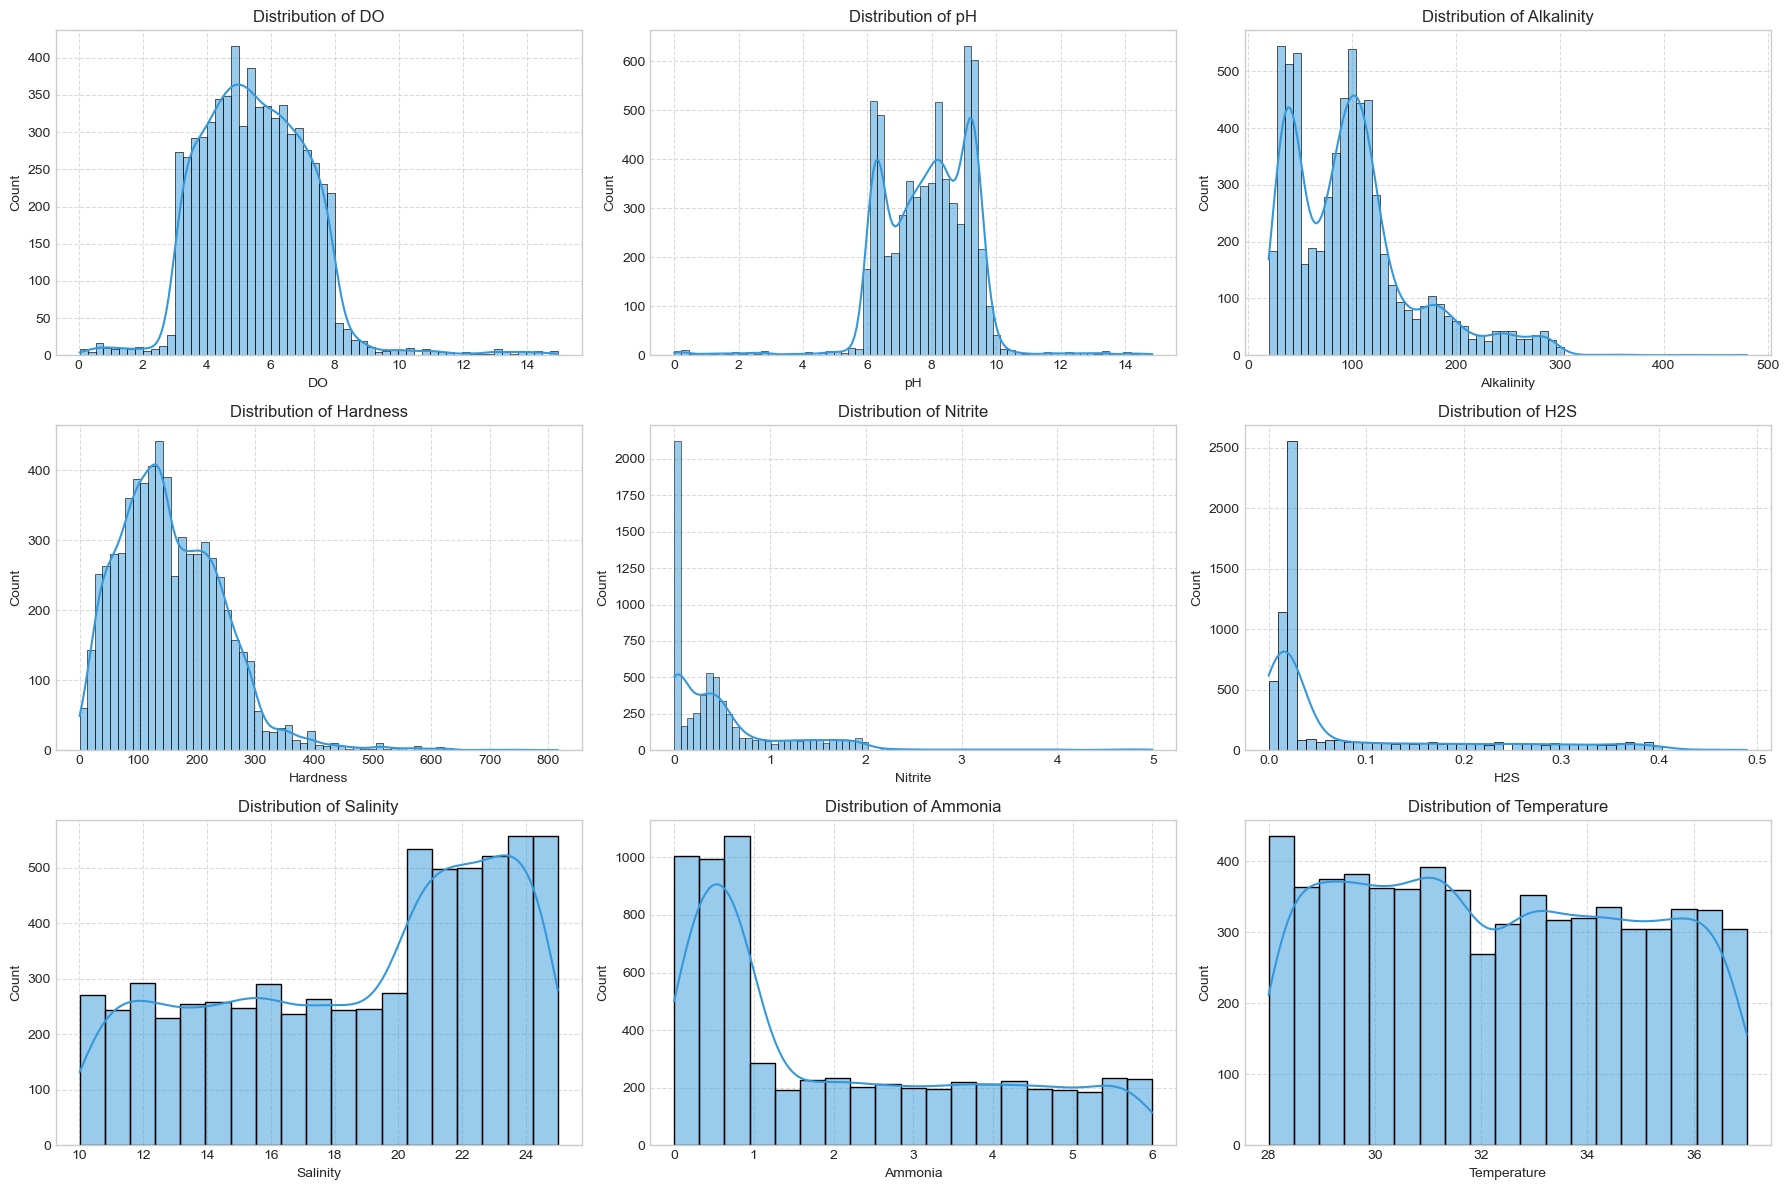

### Class Distribution:

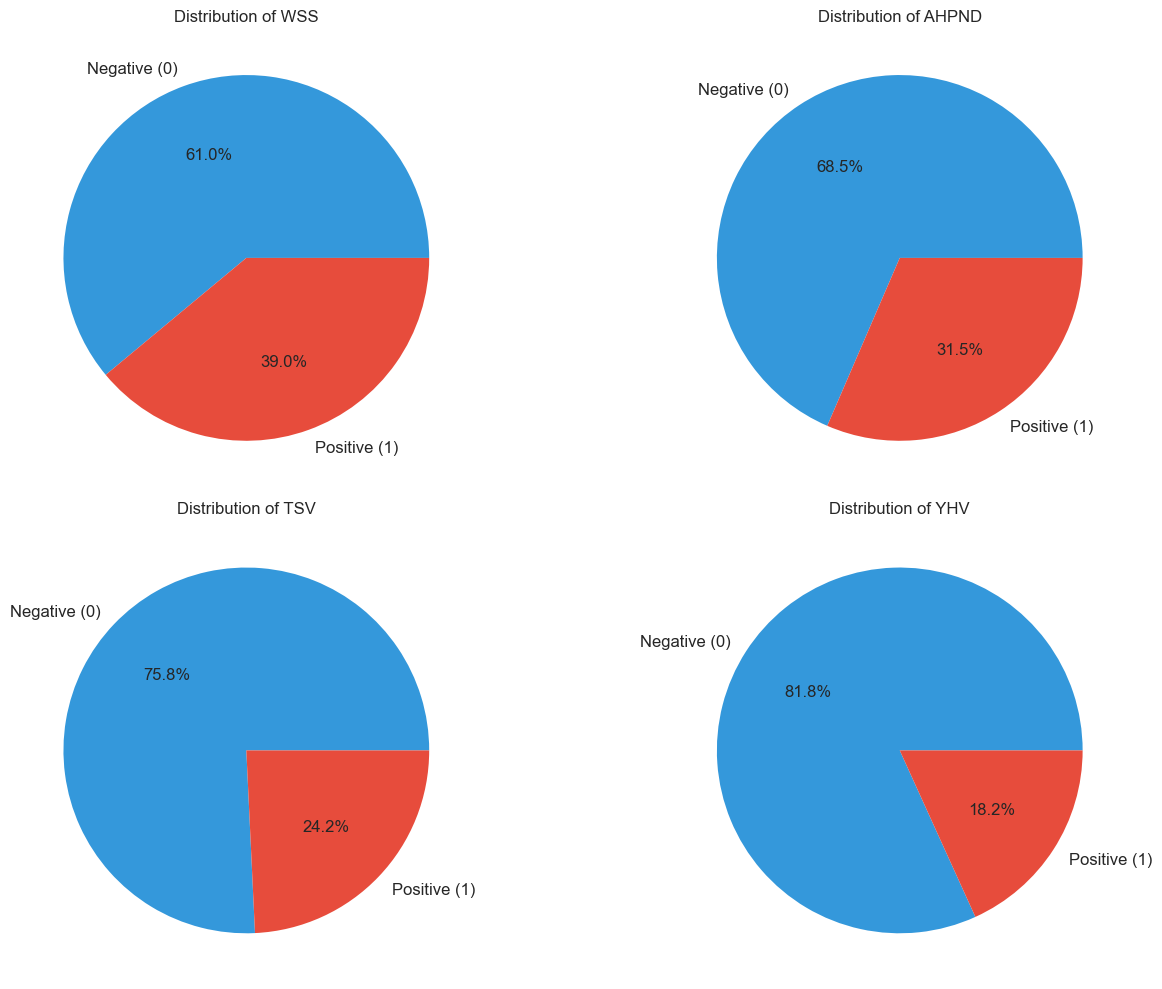

No missing values detected.


### Feature Correlations:

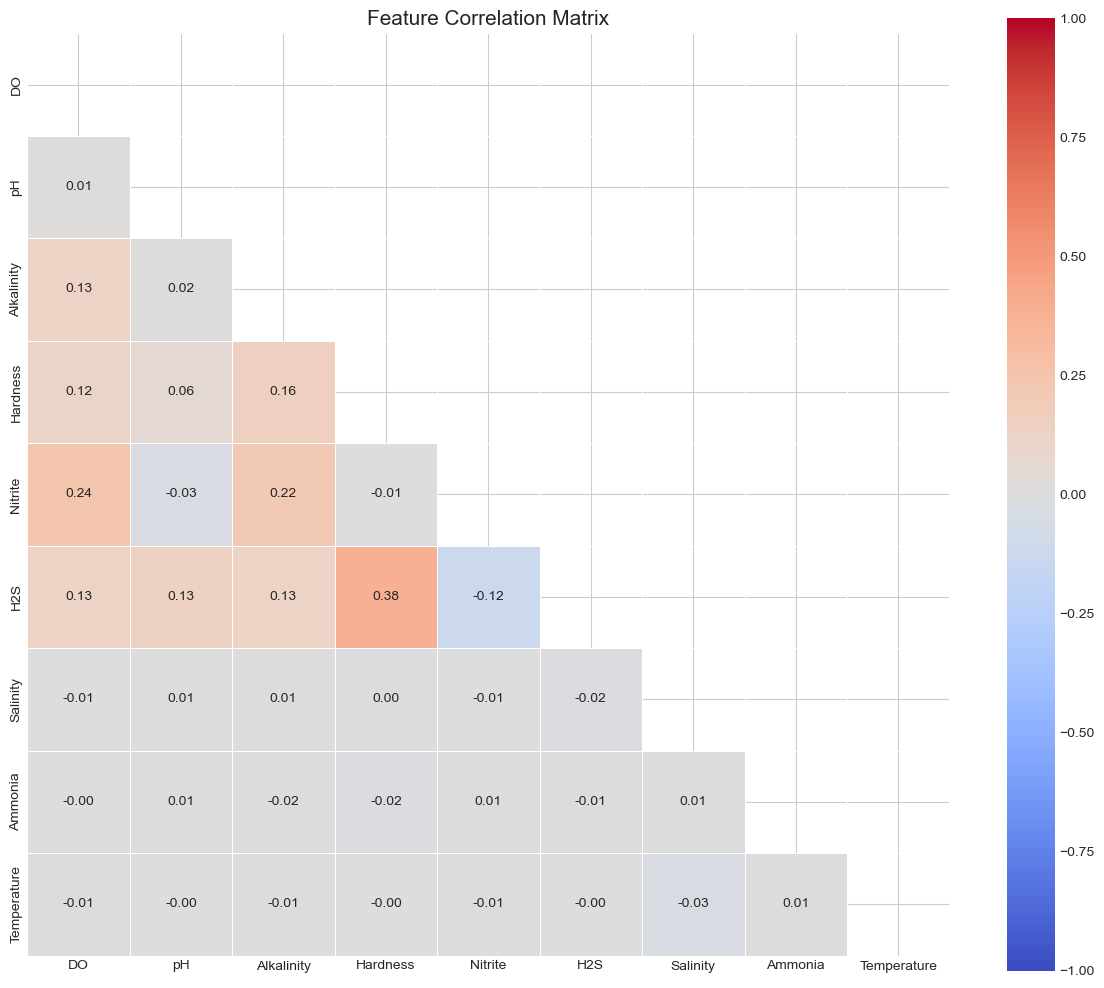

### Disease Co-occurrence:

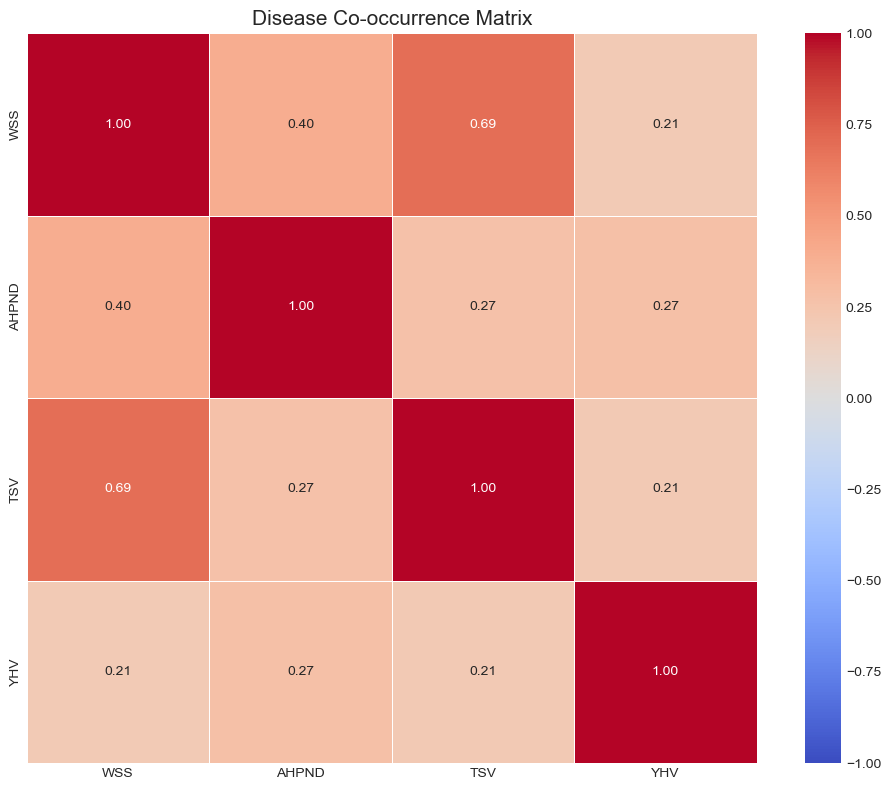

### Feature Scaling Effect:

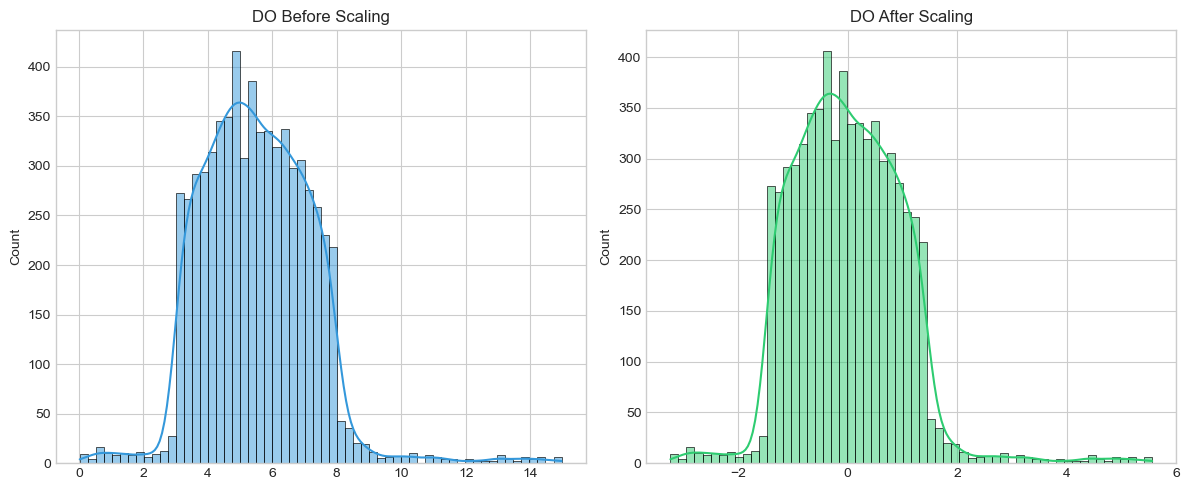


Features shape after preprocessing: (6517, 9)
Labels shape after preprocessing: (6517, 4)


## 3. Train-Test Split

Training set size: 5213 samples
Testing set size: 1304 samples


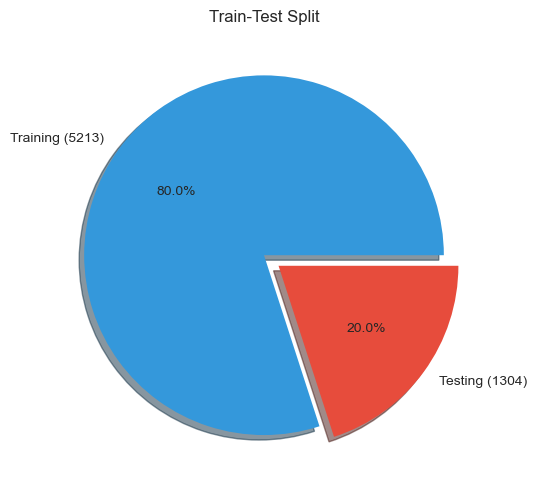

NameError: name 'target_cols' is not defined

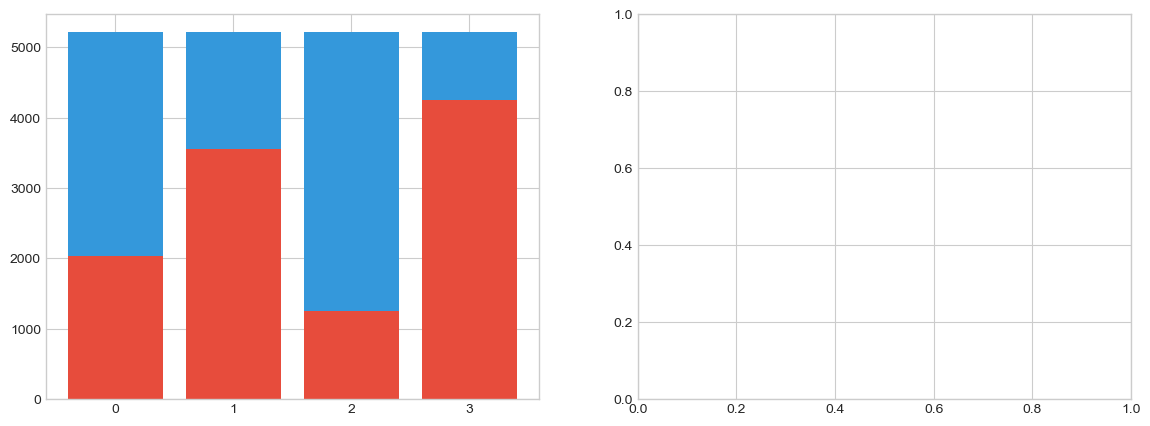

In [14]:
if __name__ == "__main__":
    # Configure file path - modify as needed
    data_file = r"C:\Users\naren\Desktop\4thyear models\Untitled Folder\dataset.csv"
    
    # Run the complete pipeline
    pipeline_results = run_pipeline(data_file)
    
    # Optional: Example of how to load and use the model for new predictions
    if pipeline_results:
        print("\nExample: Loading and using saved model")
        
        # Load models and metadata
        models = {}
        for disease in pipeline_results['target_cols']:
            model_path = os.path.join('model', f"rf_model_{disease}.pkl")
            models[disease] = joblib.load(model_path)
        
        scaler_path = os.path.join('model', "scaler.pkl")
        scaler = joblib.load(scaler_path)
        
        # Create sample data
        sample_features = np.random.rand(2, len(pipeline_results['feature_cols']))
        sample_df = pd.DataFrame(sample_features, columns=pipeline_results['feature_cols'])
        
        # Make predictions
        predictions = predict_new_cases(
            models, 
            scaler, 
            pipeline_results['feature_cols'], 
            pipeline_results['target_cols'], 
            sample_df
        )
        
        print("\nPredictions on random data:")
        display(predictions)
        
        print("\nPipeline execution completed successfully!")